# Neural Networks and MNIST

Kevin Nolasco

Cabrini University

MCIS560 - Intro to Machine Learning

02/27/2022

## Introduction

The purpose of this module is to get hands on experience building and tweaking a neural network using tensorflow. We will apply what we have learned about Neural Networks to the MNIST dataset. Our goal is to build a model that will have >98% accuracy on the test set.

## Summary

Creating a model using tf.keras is simple and powerful. It is very important to pay attention to the learning rates, batch_size, and number of epochs used when training a neural network. It is also important to process the data correctly, so that we don't run into the issue of exploding gradients and get nan results for the loss and accuracy.

After carefully tuning the model, I was able to attain an accuracy of 98.12% on the test set.

### Load the Data

Load the data. See what type is the data to know which methods are available and to learn more about the data.

In [262]:
from tensorflow import keras
import tensorflow as tf 

In [263]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

In [264]:
type(X_train)

numpy.ndarray

In [265]:
X_train.shape

(60000, 28, 28)

In [266]:
y_train.shape

(60000,)

In [267]:
X_test.shape

(10000, 28, 28)

## Apply DropOut to Images
I will use the same technique that I used in Module 3; use a threshold change the data to binary. 

In [268]:
# reshape data
def reshape_X_and_y(X, y):
    return X.reshape(X.shape[0], -1), y.reshape(y.shape[0], -1)

In [269]:
X_train, y_train = reshape_X_and_y(X_train, y_train)
X_test, y_test = reshape_X_and_y(X_test, y_test)

In [270]:
# find threshold
row_means = X_train.mean(axis = 1)
threshold = row_means.max()
print(threshold)

101.3813775510204


In [271]:
import numpy as np
vectorized_threshold = np.vectorize(lambda val: 0 if val < threshold else 1)

X_train_dropout = vectorized_threshold(X_train)
X_test_dropout = vectorized_threshold(X_test)

Now let's take an example in the training set and visualize it's dropout counter-part.

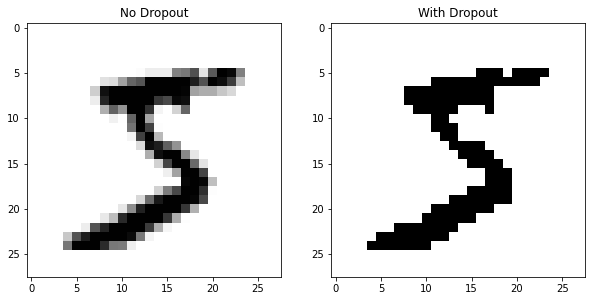

In [272]:
# visualize before and after dropout
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl

fig, axs = plt.subplots(1,2)
fig.set_size_inches(10,20)

example = X_train[0].reshape(28,28)
example_dropout = X_train_dropout[0].reshape(28,28)
axs[0].imshow(example, cmap = mpl.cm.binary)
axs[0].set_title('No Dropout')
axs[1].imshow(example_dropout, cmap = mpl.cm.binary)
axs[1].set_title('With Dropout')

plt.show()

## Goal

Use Functional API to build a wide model that takes in three inputs. The first input will go through 5 layers. The second input will go through the last 2 layers. The final input will be fed through to the end.

In [273]:
def build_model(input_shape):
    # inputs
    input_wide = keras.layers.Input(shape = [input_shape], name = 'wide')
    input_shallow = keras.layers.Input(shape = [input_shape], name = 'shallow')
    input_deep = keras.layers.Input(shape = [input_shape], name = 'deep')

    # layers
    hidden1 = keras.layers.Dense(256, activation = 'relu')(input_deep)
    hidden2 = keras.layers.Dense(256, activation = 'relu')(hidden1)
    hidden3 = keras.layers.Dense(256, activation = 'relu')(hidden2)
    # concat with input shallow
    concat_1 = keras.layers.concatenate([input_shallow, hidden3])
    hidden4 = keras.layers.Dense(256, activation = 'relu')(concat_1)
    hidden_final = keras.layers.Dense(256, activation = 'relu')(hidden4)
    # concat with final deep input
    concat_final = keras.layers.concatenate([input_wide, hidden_final])
    output = keras.layers.Dense(10, name = 'output', activation = 'softmax')(concat_final)
    model = keras.Model(inputs = [input_deep, input_shallow, input_wide], outputs = [output])
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = keras.optimizers.SGD(learning_rate = 1e-3), metrics = ['accuracy'])
    return model

In [274]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
my_nn = build_model(X_train.shape[1])

In [275]:
my_nn.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 deep (InputLayer)              [(None, 784)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          200960      ['deep[0][0]']                   
                                                                                                  
 dense_1 (Dense)                (None, 256)          65792       ['dense[0][0]']                  
                                                                                                  
 shallow (InputLayer)           [(None, 784)]        0           []                               
                                                                                              

In [276]:
# make a validation set from training set
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train_dropout, y_train, train_size = 0.75, random_state = 28)

In [277]:
# fit the model
history = my_nn.fit([X_train, X_train, X_train], y_train, epochs = 50, validation_data = ([X_valid, X_valid, X_valid], y_valid),  batch_size = 128)

Epoch 1/50
352/352 [==============================] - 2s 4ms/step - loss: 2.1875 - accuracy: 0.2203 - val_loss: 1.9592 - val_accuracy: 0.4095
Epoch 2/50
352/352 [==============================] - 1s 4ms/step - loss: 1.7824 - accuracy: 0.5466 - val_loss: 1.6381 - val_accuracy: 0.6316
Epoch 3/50
352/352 [==============================] - 1s 4ms/step - loss: 1.5079 - accuracy: 0.6855 - val_loss: 1.4074 - val_accuracy: 0.7133
Epoch 4/50
352/352 [==============================] - 1s 4ms/step - loss: 1.3095 - accuracy: 0.7416 - val_loss: 1.2386 - val_accuracy: 0.7514
Epoch 5/50
352/352 [==============================] - 1s 4ms/step - loss: 1.1631 - accuracy: 0.7720 - val_loss: 1.1121 - val_accuracy: 0.7778
Epoch 6/50
352/352 [==============================] - 1s 4ms/step - loss: 1.0521 - accuracy: 0.7917 - val_loss: 1.0147 - val_accuracy: 0.7949
Epoch 7/50
352/352 [==============================] - 1s 4ms/step - loss: 0.9656 - accuracy: 0.8050 - val_loss: 0.9377 - val_accuracy: 0.8067
Epoch 

Looks like we got a pretty high accuracy score on the validation set. 

Next I would like to see if scaling the data would help improve the validation accuracy.

## Apply Standard Scaler to Dataset

In [278]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train, y_train = reshape_X_and_y(X_train, y_train)
X_test, y_test = reshape_X_and_y(X_test, y_test)

In [279]:
X_train_tr = X_train / 255.0
X_test_tr = X_test / 255.0

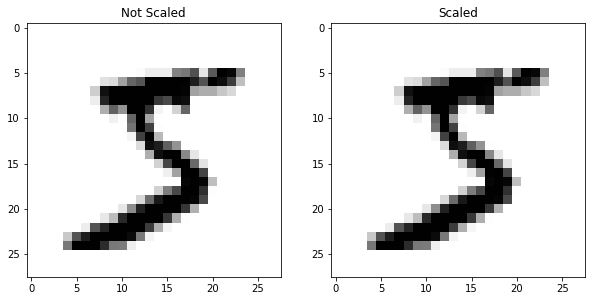

In [280]:
# visualize before and after scaling
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl

fig, axs = plt.subplots(1,2)
fig.set_size_inches(10,20)

example = X_train[0].reshape(28,28)
example_tr = X_train_tr[0].reshape(28,28)
axs[0].imshow(example, cmap = mpl.cm.binary)
axs[0].set_title('Not Scaled')
axs[1].imshow(example_tr, cmap = mpl.cm.binary)
axs[1].set_title('Scaled')

plt.show()

In [281]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_tr, y_train, train_size = 0.75, random_state = 48)

In [282]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
my_model2 = build_model(X_train.shape[1])

In [283]:
# fit model
history = my_nn.fit([X_train, X_train, X_train], y_train, epochs = 50, validation_data = ([X_valid, X_valid, X_valid], y_valid),  batch_size = 128)

Epoch 1/50
352/352 [==============================] - 2s 4ms/step - loss: 0.3886 - accuracy: 0.8990 - val_loss: 0.3859 - val_accuracy: 0.8970
Epoch 2/50
352/352 [==============================] - 1s 4ms/step - loss: 0.3850 - accuracy: 0.8993 - val_loss: 0.3826 - val_accuracy: 0.8975
Epoch 3/50
352/352 [==============================] - 2s 4ms/step - loss: 0.3815 - accuracy: 0.9001 - val_loss: 0.3794 - val_accuracy: 0.8979
Epoch 4/50
352/352 [==============================] - 2s 4ms/step - loss: 0.3782 - accuracy: 0.9009 - val_loss: 0.3764 - val_accuracy: 0.8984
Epoch 5/50
352/352 [==============================] - 2s 4ms/step - loss: 0.3750 - accuracy: 0.9011 - val_loss: 0.3732 - val_accuracy: 0.8991
Epoch 6/50
352/352 [==============================] - 2s 4ms/step - loss: 0.3720 - accuracy: 0.9016 - val_loss: 0.3705 - val_accuracy: 0.8991
Epoch 7/50
352/352 [==============================] - 1s 4ms/step - loss: 0.3690 - accuracy: 0.9021 - val_loss: 0.3676 - val_accuracy: 0.8993
Epoch 

Looks like the scaled dataset performed better than the dropout set. We will use the scaled dataset and try to find the optimal parameters for the model.

Let's use a callback to find the best learning rate for the model.

The cell below is taken from [the hands on machine learning repository](https://github.com/knolasco/handson-ml2/blob/master/10_neural_nets_with_keras.ipynb).

In [284]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

In [285]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

my_nn_w_callback = build_model(X_train.shape[1])
exp_lr = ExponentialLearningRate(factor = 1.005) # increase by 0.5% each time

In [286]:
history = my_nn_w_callback.fit([X_train, X_train, X_train], y_train, epochs = 10, validation_data = ([X_valid, X_valid, X_valid], y_valid), callbacks = [exp_lr], batch_size = 256)

Epoch 1/10
176/176 [==============================] - 2s 8ms/step - loss: 2.2736 - accuracy: 0.1542 - val_loss: 2.0637 - val_accuracy: 0.3291
Epoch 2/10
176/176 [==============================] - 1s 7ms/step - loss: 1.8097 - accuracy: 0.5501 - val_loss: 1.5279 - val_accuracy: 0.7059
Epoch 3/10
176/176 [==============================] - 1s 7ms/step - loss: 1.2348 - accuracy: 0.7705 - val_loss: 0.9652 - val_accuracy: 0.8171
Epoch 4/10
176/176 [==============================] - 1s 7ms/step - loss: 0.7624 - accuracy: 0.8398 - val_loss: 0.5975 - val_accuracy: 0.8621
Epoch 5/10
176/176 [==============================] - 1s 7ms/step - loss: 0.4888 - accuracy: 0.8763 - val_loss: 0.4020 - val_accuracy: 0.8879
Epoch 6/10
176/176 [==============================] - 1s 8ms/step - loss: 0.3485 - accuracy: 0.9032 - val_loss: 0.2988 - val_accuracy: 0.9149
Epoch 7/10
176/176 [==============================] - 1s 7ms/step - loss: 0.2806 - accuracy: 0.9182 - val_loss: 0.3738 - val_accuracy: 0.8787
Epoch 

Now let's plot the loss against the learning rate to find the best learning rate.

Text(0, 0.5, 'Loss')

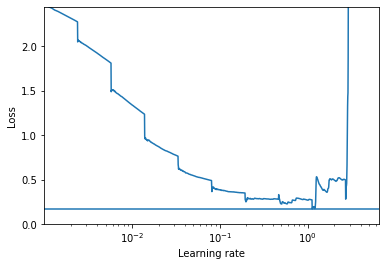

In [287]:
plt.plot(exp_lr.rates, exp_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(exp_lr.losses), min(exp_lr.rates), max(exp_lr.rates))
plt.axis([min(exp_lr.rates), max(exp_lr.rates), 0, exp_lr.losses[0]])
plt.xlabel("Learning rate")
plt.ylabel("Loss")

In [288]:
type(exp_lr.losses)

list

In [289]:
# get the min index for where the minimum loss occurs
val, idx = min((val, idx) for (idx, val) in enumerate(exp_lr.losses))

In [290]:
val, exp_lr.rates[idx]

(0.16867539286613464, 1.1215323)

Let's create another model with the same structure but the optimal learning rate. We will also use an early stopping call back and prepare the model to use tensorboard.

In [291]:
def build_model_optimized(input_shape, best_lr):
    # inputs
    input_wide = keras.layers.Input(shape = [input_shape], name = 'wide')
    input_shallow = keras.layers.Input(shape = [input_shape], name = 'shallow')
    input_deep = keras.layers.Input(shape = [input_shape], name = 'deep')

    # layers
    hidden1 = keras.layers.Dense(256, activation = 'relu')(input_deep)
    hidden2 = keras.layers.Dense(256, activation = 'relu')(hidden1)
    hidden3 = keras.layers.Dense(256, activation = 'relu')(hidden2)
    # concat with input shallow
    concat_1 = keras.layers.concatenate([input_shallow, hidden3])
    hidden4 = keras.layers.Dense(256, activation = 'relu')(concat_1)
    hidden_final = keras.layers.Dense(256, activation = 'relu')(hidden4)
    # concat with final deep input
    concat_final = keras.layers.concatenate([input_wide, hidden_final])
    output = keras.layers.Dense(10, name = 'output', activation = 'softmax')(concat_final)
    model = keras.Model(inputs = [input_deep, input_shallow, input_wide], outputs = [output])
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = keras.optimizers.SGD(learning_rate = best_lr), metrics = ['accuracy'])
    return model

In [292]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
best_model = build_model_optimized(X_train.shape[1], best_lr = exp_lr.rates[idx])

In [293]:
import os
run_index = 1 # increment this at every run
run_logdir = os.path.join(os.curdir, "my_mnist_logs", "run_{:03d}".format(run_index))
run_logdir

'.\\my_mnist_logs\\run_001'

In [294]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 15)
checkpoint_cb = keras.callbacks.ModelCheckpoint('my_mnist_best_model.h5', save_best_only = True)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = best_model.fit([X_train, X_train, X_train], y_train, epochs = 75, 
                        validation_data = ([X_valid, X_valid, X_valid], y_valid), batch_size = 64, callbacks = [early_stopping_cb, checkpoint_cb, tensorboard_cb])

Epoch 1/75
704/704 [==============================] - 2s 3ms/step - loss: 0.3979 - accuracy: 0.8927 - val_loss: 0.2618 - val_accuracy: 0.9245
Epoch 2/75
704/704 [==============================] - 2s 3ms/step - loss: 0.1855 - accuracy: 0.9475 - val_loss: 0.1854 - val_accuracy: 0.9502
Epoch 3/75
704/704 [==============================] - 2s 3ms/step - loss: 0.1342 - accuracy: 0.9624 - val_loss: 0.1518 - val_accuracy: 0.9591
Epoch 4/75
704/704 [==============================] - 2s 4ms/step - loss: 0.0972 - accuracy: 0.9714 - val_loss: 0.1177 - val_accuracy: 0.9696
Epoch 5/75
704/704 [==============================] - 2s 3ms/step - loss: 0.0824 - accuracy: 0.9756 - val_loss: 1.8977 - val_accuracy: 0.7167
Epoch 6/75
704/704 [==============================] - 2s 3ms/step - loss: 0.0802 - accuracy: 0.9771 - val_loss: 0.1293 - val_accuracy: 0.9678
Epoch 7/75
704/704 [==============================] - 2s 3ms/step - loss: 0.0527 - accuracy: 0.9838 - val_loss: 0.6006 - val_accuracy: 0.9133
Epoch 

Looks like the model stopped training after 33 of the 75 epochs. Let's see how it performs on the test set.

In [295]:
model = keras.models.load_model("my_mnist_best_model.h5") # rollback to best model
y_test_preds = model.predict([X_test_tr, X_test_tr, X_test_tr])

In [296]:
acc = model.evaluate([X_test_tr, X_test_tr, X_test_tr], y_test)

print('Accuracy on test set: {:.2%}'.format(acc[1]))

313/313 [==============================] - 0s 834us/step - loss: 0.0965 - accuracy: 0.9812
Accuracy on test set: 98.12%


In [297]:
%tensorboard --logdir=./my_mnist_logs --port=6006

UsageError: Line magic function `%tensorboard` not found.


# Conclusion

From the tensorboard results (not shown here), we can see that the training accuracy leveled off at 100%. Although this is typically a sign of overfitting, we can see that the validation accuracy converged nicely to 98.23% when training the model. Moreover, this accuracy translated very well with the test set and we ended with a model that is 98.12% accurate in data that it has never seen before.

There were many take aways from this module. I struggled to understand what callbacks are and how to use them the first time I encountered them, but I feel like I have a much better understanding of them now. I will continue to learn tensorflow and apply it to problems that I encounter in the future.

Thank you for reading.